In [1]:
# Dependencies
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from IPython.display import HTML, Image
import warnings
from nocturne.envs.base_env import BaseEnv
from pathlib import Path
from pyvirtualdisplay import Display
import torch
import imageio
import matplotlib.pyplot as plt
from utils.config import load_config_nb
from utils.sb3.reg_ppo import RegularizedPPO

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')

H_COLUMNS = ['Reg. weight', 'Train agent', 'Dataset', 'Eval mode']
METRICS = ['goal_rate', 'veh_veh_collision', 'off_road']
models_config = load_config_nb('model_config_02')
env_config = load_config_nb('env_config')

### Helper functions

In [2]:
def mean_plus_min_std(ser: pd.Series, scale: float = 100) -> str:
    return f"{ser.mean() * 100:.2f} ± {(ser * 100).std():.2f}"

def mean_perc(ser: pd.Series) -> float:
    return ser.mean() * 100

### **Load results**

In [3]:
# Load data
df_all = pd.read_csv('../df_agg_performance_ip_0131_S50_v2.csv')

mapping = {
    np.nan: "BC",
    0.0: "PPO",
    0.005: "HR-PPO | λ = 0.005",
    0.01: "HR-PPO | λ = 0.01",
    0.025: "HR-PPO | λ = 0.025",
    0.05: "HR-PPO | λ = 0.05",
    0.5: "HR-PPO | λ = 0.5",
    0.2: "HR-PPO | λ = 0.2",
    0.1: "HR-PPO | λ = 0.1",
}

df_all["Reg. weight"] = df_all["Reg. weight"].replace(mapping)

In [4]:
# Sanity check
df_all.scene_id.sort_values().unique().shape

(50,)

In [5]:
df_all.tot_int_paths.value_counts()

tot_int_paths
0.0    5265
1.0    1845
2.0    1725
4.0     990
7.0     801
5.0     552
9.0     321
3.0     183
Name: count, dtype: int64

In [138]:
df_all_filtered = df_all[df_all['Reg. weight'].isin(['PPO', 'HR-PPO | λ = 0.025'])]

### 1. What is the **aggregate performance**?

In [113]:
df_agg_perf = df_all.pivot_table(
    index=H_COLUMNS,
    values=METRICS,
    aggfunc=mean_perc
)


df_agg_perf.reindex(['PPO', 'HR-PPO | λ = 0.01', 'HR-PPO | λ = 0.025'], level=0).style.format("{:.2f}")

### 2. How does HR-PPO do overall?

In [139]:
df_agg_coll_by_scene = df_all_filtered.pivot_table(
    index=['scene_id'],
    columns=['Eval mode', 'Reg. weight'],
    values='veh_veh_collision', # Num total vehicles doesn't make sense
    aggfunc=mean_perc,
)

df_agg_coll_by_scene.style.format(precision=2)

In [140]:
df_all['Reg. weight'].unique()

array(['PPO', 'HR-PPO | λ = 0.01', 'HR-PPO | λ = 0.025'], dtype=object)

Reg. weight,HR-PPO | λ = 0.025,PPO
Eval mode,,
Log-replay,16.33,25.07
Self-play,5.35,9.90


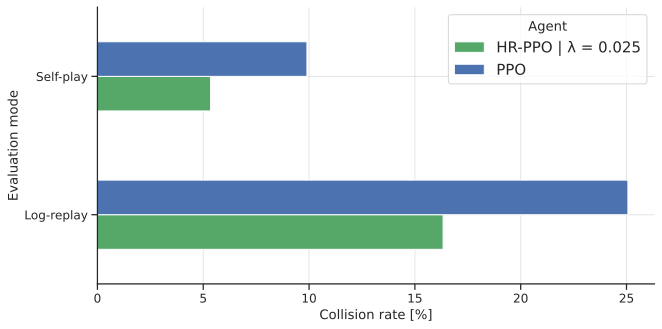

In [145]:
df_all_piv = df_all_filtered.pivot_table(
    index=["Eval mode"],
    columns=['Reg. weight'],
    values='veh_veh_collision', # Num total vehicles doesn't make sense
    aggfunc=mean_perc,
)

display(df_all_piv.style.format(precision=2))

# Set the seaborn color palette to 'colorblind'
sns.set_palette('colorblind')

# Fetch the current colorblind color palette
colors = sns.color_palette('colorblind')

# Use the colors in the barh plot
df_all_piv.plot(kind="barh", color=['g', 'b',])

plt.grid(True, alpha=0.5)
sns.despine()
plt.legend(facecolor='white', title='Agent', fontsize=15)
plt.ylabel("Evaluation mode")
plt.xlabel("Collision rate [%]")
plt.savefig(f"../evaluation/figures/isolate_error/overall_comp.pdf", bbox_inches='tight')

### Question 2: Do PPO and HR-PPO struggle with the same scenes?

In [117]:
df_agg_coll_by_scene

Eval mode                               Log-replay                     \
Reg. weight                      HR-PPO | λ = 0.01 HR-PPO | λ = 0.025   
scene_id                                                                
tfrecord-00001-of-01000_307.json         41.379310          41.379310   
tfrecord-00004-of-01000_378.json         16.000000           0.000000   
tfrecord-00005-of-01000_423.json          0.000000           0.000000   
tfrecord-00007-of-01000_237.json         64.705882          29.411765   
tfrecord-00012-of-01000_246.json         46.153846          19.230769   
tfrecord-00012-of-01000_389.json          9.677419           9.677419   
tfrecord-00012-of-01000_87.json          25.806452          16.129032   
tfrecord-00013-of-01000_405.json         20.833333           0.000000   
tfrecord-00019-of-01000_105.json          0.000000           0.000000   
tfrecord-00019-of-01000_117.json          0.000000           0.000000   
tfrecord-00019-of-01000_197.json          0.000000          51.428571   
tfrecord-00020-of-01000_355.json         52.173913          65.217391   
tfrecord-00020-of-01000_383.json          0.000000           0.000000   
tfrecord-00023-of-01000_197.json         22.222222           0.000000   
tfrecord-00024-of-01000_33.json           0.000000           0.000000   
tfrecord-00026-of-01000_68.json          48.387097           9.677419   
tfrecord-00028-of-01000_309.json          0.000000          53.846154   
tfrecord-00030-of-01000_106.json         41.666667           0.000000   
tfrecord-00030-of-01000_482.json          0.000000           0.000000   
tfrecord-00031-of-01000_115.json         52.777778           0.000000   
tfrecord-00031-of-01000_123.json         25.000000          25.000000   
tfrecord-00031-of-01000_45.json          22.500000          20.000000   
tfrecord-00033-of-01000_16.json           0.000000           0.000000   
tfrecord-00033-of-01000_289.json         27.272727           9.090909   
tfrecord-00036-of-01000_503.json          0.000000           0.000000   
tfrecord-00037-of-01000_109.json          0.000000           0.000000   
tfrecord-00038-of-01000_205.json         20.000000          20.000000   
tfrecord-00038-of-01000_57.json           0.000000           0.000000   
tfrecord-00040-of-01000_355.json         38.297872          29.787234   
tfrecord-00040-of-01000_414.json         17.241379          24.137931   
tfrecord-00040-of-01000_427.json         28.947368          23.684211   
tfrecord-00042-of-01000_418.json         22.857143           0.000000   
tfrecord-00042-of-01000_452.json         32.000000          32.000000   
tfrecord-00044-of-01000_166.json         64.705882          64.705882   
tfrecord-00045-of-01000_264.json         62.068966          31.034483   
tfrecord-00045-of-01000_408.json         42.857143          35.714286   
tfrecord-00047-of-01000_177.json          0.000000          55.555556   
tfrecord-00047-of-01000_180.json          0.000000          44.444444   
tfrecord-00051-of-01000_21.json           0.000000           0.000000   
tfrecord-00051-of-01000_60.json          26.923077          26.923077   
tfrecord-00052-of-01000_22.json           0.000000           0.000000   
tfrecord-00053-of-01000_164.json          0.000000           0.000000   
tfrecord-00054-of-01000_353.json          0.000000           0.000000   
tfrecord-00058-of-01000_108.json         33.333333           0.000000   
tfrecord-00058-of-01000_428.json          0.000000           0.000000   
tfrecord-00059-of-01000_12.json           0.000000           0.000000   
tfrecord-00060-of-01000_450.json         12.500000          12.500000   
tfrecord-00061-of-01000_150.json          5.882353           5.882353   
tfrecord-00061-of-01000_223.json         44.444444          44.444444   
tfrecord-00062-of-01000_391.json         15.625000          15.625000   

Eval mode                                           Self-play  \
Reg. weight                             PPO HR-PPO | λ = 0.01   


In [118]:
df_agg_coll_by_scene.columns.levels[0]

Index(['Log-replay', 'Self-play'], dtype='object', name='Eval mode')

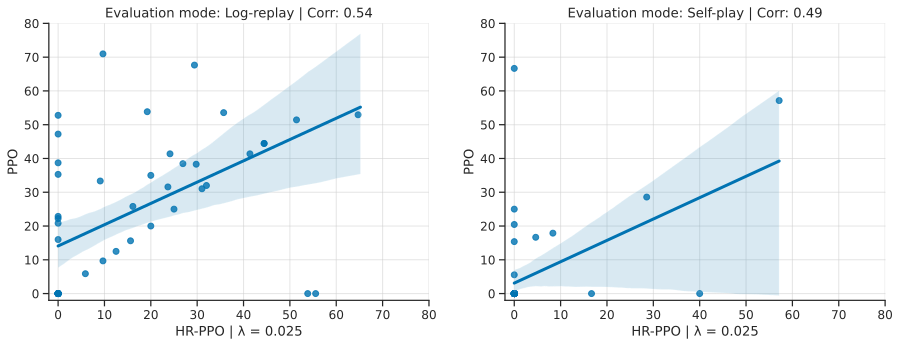

In [151]:
import scipy

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for idx, eval_mode in enumerate(df_agg_coll_by_scene.columns.levels[0]):
    df_select = df_agg_coll_by_scene[eval_mode]
    sns.regplot(data=df_select, x="HR-PPO | λ = 0.025", y="PPO", ax=axes[idx])
    corr, _ = scipy.stats.pearsonr(df_select["HR-PPO | λ = 0.025"], df_select["PPO"])
    axes[idx].set_title(f"Evaluation mode: {eval_mode} | Corr: {corr:.2f}")
    # sns.scatterplot(data=df_agg_coll_by_scene[eval_mode], x='HR-PPO', y="PPO", ax=axes[idx])

    axes[idx].grid(True, alpha=0.5)
    axes[idx].set_xlim(-2, 80)
    axes[idx].set_ylim(-2, 80)
sns.despine()

plt.savefig(f'../evaluation/figures/isolate_error/errors_corr_log_replay.pdf', bbox_inches="tight")

### Question 3: Are the same scenes difficult in self-play and log-replay mode?

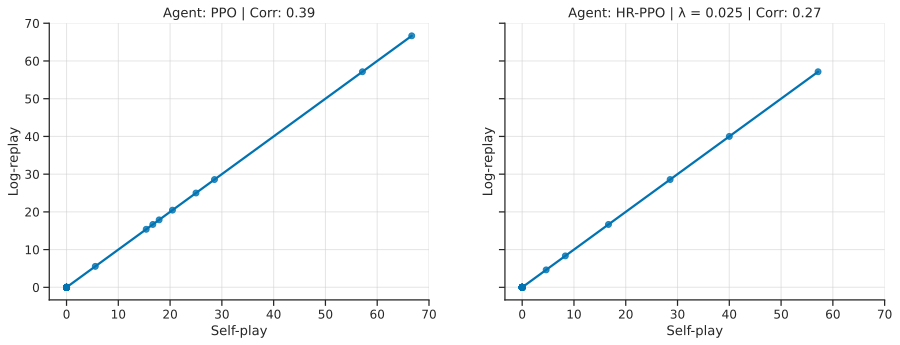

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

for idx, agent in enumerate(["PPO", "HR-PPO | λ = 0.025"]):

    df_agent_lr = df_agg_coll_by_scene['Self-play'][agent]
    df_agent_sp = df_agg_coll_by_scene['Log-replay'][agent]
    
    sns.regplot(x=df_agent_lr.values, y=df_agent_lr.values, ax=axes[idx])
    corr, _ = scipy.stats.pearsonr(df_agent_lr.values, df_agent_sp.values)
    axes[idx].set_title(f"Agent: {agent} | Corr: {corr:.2f}")
    
    axes[idx].grid(True, alpha=0.5)
    axes[idx].set_xlabel("Self-play")
    axes[idx].set_ylabel("Log-replay")
    sns.despine()

plt.show()

### Question 4: What drives the difficulty, the scene as a whole (coordination) or individual trajectories 

In [121]:
BINS = [-1, 0, 1, 2, float('inf')]
LABELS = ['0', '1', '2', '3+']

In [122]:
df_sp = df_all[df_all['Eval mode'] == 'Self-play']

In [123]:
# Aggregate results in self-play evaluation mode
df_sp = df_all[df_all['Eval mode'] == 'Self-play']
df_sp['int_path_cat'] = pd.cut(df_sp['veh_int_paths'], bins=BINS, labels=LABELS, include_lowest=True)
df_sp_agg = df_sp.groupby(['Reg. weight', 'int_path_cat'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean()
df_sp_agg['goal_rate'] = df_sp_agg['goal_rate'] * 100
df_sp_agg['off_road'] = df_sp_agg['off_road'] * 100
df_sp_agg['veh_veh_collision'] = df_sp_agg['veh_veh_collision'] * 100

# Aggregate results in self-play evaluation mode
df_lr = df_all[df_all['Eval mode'] == 'Log-replay']
df_lr['int_path_cat'] = pd.cut(df_lr['veh_int_paths'], bins=BINS, labels=LABELS, include_lowest=True)
df_lr_agg = df_lr.groupby(['Reg. weight', 'int_path_cat'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean()
df_lr_agg['goal_rate'] = df_lr_agg['goal_rate'] * 100
df_lr_agg['off_road'] = df_lr_agg['off_road'] * 100
df_lr_agg['veh_veh_collision'] = df_lr_agg['veh_veh_collision'] * 100

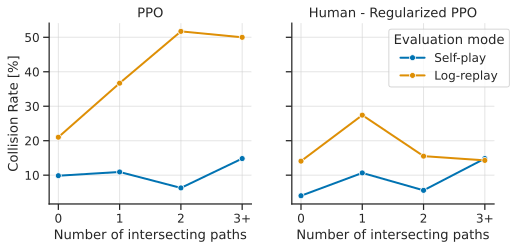

In [148]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2

df_log_replay_reset = df_lr_agg.reset_index()
df_self_play_reset = df_sp_agg.reset_index()

REG_WEIGHT = "HR-PPO | λ = 0.025"

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# PPO
sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_self_play_reset[df_self_play_reset['Reg. weight'] == "PPO"], 
    ax=axs[0],
    marker='o',
)

sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_log_replay_reset[df_log_replay_reset['Reg. weight'] == "PPO"], 
    ax=axs[0],
    marker='o',
)

# HR-PPO
sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_self_play_reset[df_self_play_reset['Reg. weight'] == REG_WEIGHT], 
    ax=axs[1],
    marker='o',
    label='Self-play',
)

sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_log_replay_reset[df_log_replay_reset['Reg. weight'] == REG_WEIGHT], 
    ax=axs[1],
    marker='o',
    label='Log-replay',
)

axs[1].legend(title='Evaluation mode', loc='upper left', bbox_to_anchor=(.45, 1), facecolor='white')
axs[0].set_title(r'PPO')
axs[1].set_title(r'Human - Regularized PPO')
axs[0].set_ylabel('Collision Rate [%]')
axs[0].set_xlabel('Number of intersecting paths')
axs[1].set_xlabel('Number of intersecting paths')
fig.subplots_adjust(bottom=0.25)
axs[1].grid(True, alpha=0.5), axs[0].grid(True, alpha=0.5)
sns.despine()

plt.savefig(f'../evaluation/figures/isolate_error/coordination_self_play_vs_expert.pdf', bbox_inches="tight")

In [149]:
df_sp['int_path_cat'].value_counts()

int_path_cat
0     5520
1     1071
2      429
3+     162
Name: count, dtype: int64

In [150]:
df_lr['int_path_cat'].value_counts()

int_path_cat
0     3540
1      744
2      174
3+      42
Name: count, dtype: int64

## Render 

In [6]:
def create_video(image_array, filename, *, fps=4, loop=500):
    with imageio.get_writer(filename, duration=1_000 / fps, loop=loop) as writer:
        for img in image_array:
            img = np.moveaxis(img, [0, 1, 2], [2, 0, 1])
            writer.append_data(img)


def display_gif(filename, width=500, height=500):
    display(
        Image(
            data=open(filename, "rb").read(), format="gif", width=width, height=height
        )
    )

In [7]:
# Load dict with number of intersecting paths per scene
with open('../evaluation/scene_info/train_1000_01_31_15_18.pkl', 'rb') as handle:
    scene_to_paths_dict = pickle.load(handle)
    
# Create an empty dataframe
df_intersect = pd.DataFrame(columns=['traffic_scene', 'veh_id', 'intersecting_paths'])

# Populate the dataframe
for traffic_scene, data in scene_to_paths_dict.items():
    veh_ids = data['veh_id']
    intersecting_paths = data['intersecting_paths']

    # Repeat traffic_scene for each veh_id
    traffic_scene_col = [traffic_scene] * len(veh_ids)

    # Append to the dataframe
    df_intersect = pd.concat([df_intersect, pd.DataFrame(list(zip(traffic_scene_col, veh_ids, intersecting_paths)),
                                     columns=['traffic_scene', 'veh_id', 'intersecting_paths'])])

# Reset index
df_intersect.reset_index(drop=True, inplace=True)

In [38]:
NUM_INTERSECTING_PATHS = 0

VIDEO_PATH = f'../evaluation/videos/intersecting_paths_{NUM_INTERSECTING_PATHS}'

# Sample a random scene
random_scene = df_intersect[df_intersect['intersecting_paths'] == NUM_INTERSECTING_PATHS].sample(n=1) 

scene_name = str(random_scene.traffic_scene.values[0])
focus_veh_id = random_scene.veh_id.values[0]
print(random_scene)

                         traffic_scene veh_id intersecting_paths
1486  tfrecord-00237-of-01000_379.json     20                  0


In [42]:
MODEL = "HR-PPO"
VIDEO_PATH = "../evaluation/videos"

if MODEL == "PPO":
    policy = RegularizedPPO.load(
    f'../{models_config.hr_ppo_models_dir_self_play}/{models_config.best_overall_models[0].name}'
)

elif MODEL == "HR-PPO": 
    policy = RegularizedPPO.load(
        f'../{models_config.hr_ppo_models_dir_self_play}/{models_config.best_overall_models[2].name}'
    )        

env_config.max_num_vehicles = 1
env_config.data_path = '../data_full/train'
env = BaseEnv(env_config)

obs_dict = env.reset(filename=scene_name)
frames = []

for time_step in range(90):
    
    action_dict = {}
    for agent_id in obs_dict:
        # Get observation
        obs = torch.from_numpy(obs_dict[agent_id]).unsqueeze(dim=0)

        # Get action
        action, _ = policy.predict(obs, deterministic=True)
        action_dict[agent_id] = int(action)

    
    if time_step % 1 == 0:
        with Display(backend="xvfb") as disp:
            render_scene = env.scenario.getImage(
                img_width=1600,
                img_height=1600,
                draw_target_positions=True,
                padding=50.0,
                source=env.controlled_vehicles[0],
                view_width=120,
                view_height=120,
                rotate_with_source=True,
            )
            frames.append(render_scene.T)

    # Step
    obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
    
    if done_dict['__all__']:
        print(info_dict[agent_id])
        break

INFO:root:No regularization weight specified, using default PPO.


{'goal_achieved': False, 'collided': True, 'veh_veh_collision': True, 'veh_edge_collision': False}


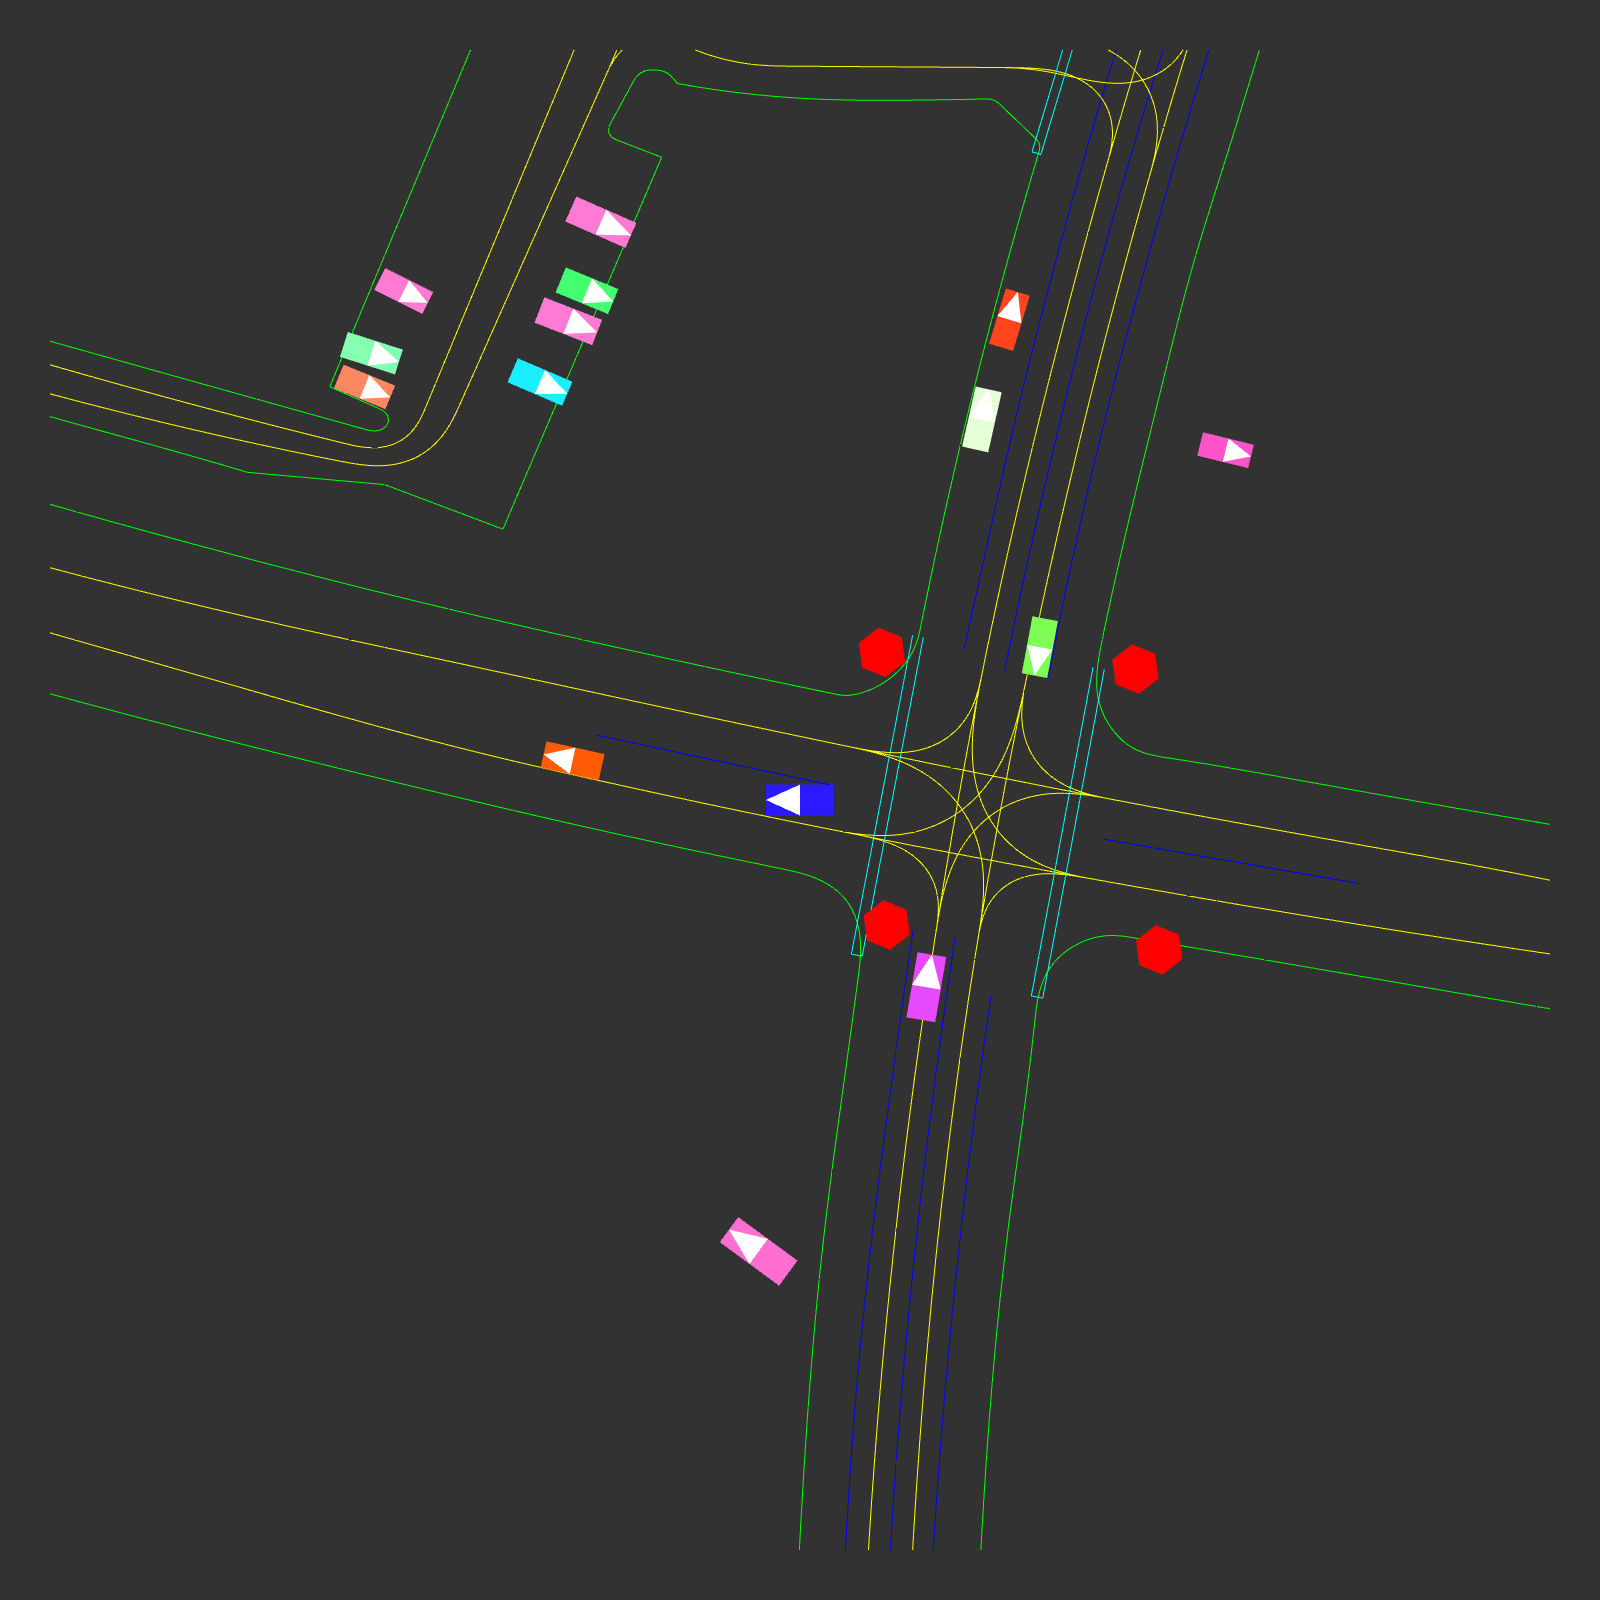

In [43]:
Path(f"{VIDEO_PATH}/{scene_name}_{MODEL}").parent.mkdir(parents=True, exist_ok=True)
create_video(frames, f"{VIDEO_PATH}/{scene_name}_{MODEL}.gif", fps=4)
display(HTML(f"<h3>{MODEL} - {scene_name}</h3>"))
display_gif(f"{VIDEO_PATH}/{scene_name}_{MODEL}.gif")